In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torchvision.transforms import Compose
import random
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from pydub import AudioSegment, silence
import pickle
import pyloudnorm as pyln

In [2]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal,title='', sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    plt.title(title)
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [3]:
import noisereduce as nr

def signum(x):
    return 1 if x>0 else -1

def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    denoised_signal = nr.reduce_noise(signal, sr=sample_rate)
    denoised_signal_boosted = np.where((np.abs(denoised_signal)>.04) & (np.abs(denoised_signal)<.4), (0.4-denoised_signal) * 1.15, denoised_signal)
    # if show:
    #     disp_waveform(denoised_signal, 'signal waveform DENOISED', sr=sample_rate)
    #     disp_waveform(signal, 'signal waveform NOISED', sr=sample_rate)
    #     disp_waveform(denoised_signal_boosted, 'signal waveform DENOISED n BOOSTED', sr=sample_rate)
    # signal = denoised_signal
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    norm = np.linalg.norm(energy)
    energy = energy/norm
    # -- energy'
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float), sr=sample_rate)
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    timestamps = []
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            if len(keystroke) >= before + after:
                strokes.append(keystroke)
                timestamps.append(timestamp)
                if show and len(strokes) <= 3:
                    disp_waveform(keystroke, title=f'keystroke {len(strokes)}', sr=sample_rate)
                prev_end = timestamp+after
    return peaks, strokes, timestamps

In [5]:
def partition_audio(samples_arr : np.array):
    ret_samples = np.abs(samples_arr)
    return ret_samples

In [98]:
import numpy as np
from collections import deque

def find_key_presses(waveform, res, waveform_threshold, waveform_max, threshold_background, history_size, remove_low_power):
    # Clear previous results
    # res.clear()
    # waveform_threshold = np.zeros_like(waveform)
    # waveform_max = np.zeros_like(waveform)
    # 
    rb_begin = 0
    rb_average = 0.0
    rb_samples = np.zeros(history_size)

    k = history_size
    que = deque(maxlen=k)

    samples = np.abs(waveform)  # Taking absolute values like waveformAbs in C++
    n = len(samples)
    overall_loudness = 0
    len_ovr_loudness = 0
    for i in range(n):
        ii = i - k // 2
        if ii >= 0:
            rb_average *= len(rb_samples)
            rb_average -= rb_samples[rb_begin]
            acur = samples[i]
            rb_samples[rb_begin] = acur
            rb_average += acur
            rb_average /= len(rb_samples)
            rb_begin = (rb_begin + 1) % len(rb_samples)
        if i < k:
            # Handling initial filling of the deque
            while que and samples[i] >= samples[que[-1]]:
                que.pop()
            que.append(i)
        else:
            # Maintain the deque as a max-queue for the sliding window
            while que and que[0] <= i - k:
                que.popleft()

            # same code as if i<k
            while que and samples[i] >= samples[que[-1]]:
                que.pop()
            que.append(i)

            itest = i - k // 2
            if  k <= itest < n - k and que[0] == itest:
                acur = samples[itest]
                if acur > threshold_background * rb_average:
                    res.append({
                        'waveform': waveform[itest - k//6 : itest + (5*k)//6],
                        'index': itest
                    })
                    quiet_part = samples[itest + (3*k)//6 : itest + (5*k)//6]
                    len_ovr_loudness += len(quiet_part)
                    overall_loudness += np.sum(quiet_part)
            waveform_threshold[itest] = threshold_background * rb_average
            waveform_max[itest] = samples[que[0]]

    if remove_low_power:
        while True:
            old_n = len(res)

            avg_power = sum(samples[kp["position"]] for kp in res) / len(res)

            tmp_res = res[:]
            res.clear()

            for kp in tmp_res:
                if samples[kp["position"]] > 0.3 * avg_power:
                    res.append(kp)

            if len(res) == old_n:
                break
                
    if len_ovr_loudness > 0:
        avg_loudness = overall_loudness / len_ovr_loudness
    else:
        avg_loudness = 0
        
    return {'waveform_threshold': waveform_threshold, 
            'waveform_max': waveform_max,
            'res': res,
            'avg_loudness': avg_loudness
            }

In [7]:
import array

def numpy_to_audiosegment(samples, sample_rate=44100, sample_width=2, channels=1):
    # Ensure the numpy array is in the correct dtype (int16 or int32 based on sample_width)
    if sample_width == 2:
        samples = np.int16(samples)
    elif sample_width == 4:
        samples = np.int32(samples)
    
    # Convert numpy array to byte data
    audio_data = array.array('h', samples)  # 'h' for 16-bit PCM audio
    byte_data = audio_data.tobytes()
    
    # Create AudioSegment
    audio_segment = AudioSegment(
        data=byte_data,
        sample_width=sample_width,  # 2 for 16-bit, 4 for 32-bit
        frame_rate=sample_rate,
        channels=channels
    )
    
    return audio_segment

In [8]:

# constants
N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000

key_length = 8820
for num in range(0, 5):
    samples, sr = librosa.load(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', sr=44100)
    pydub_samples = AudioSegment.from_file(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', format="wav", frame_rate=44100)
    
    samples2, sr = librosa.load(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', sr=44100)
    pydub_samples2 = AudioSegment.from_file(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', format='wav', 
                                           frame_rate=44100, sample_width=4)
    
    silences = silence.detect_silence(pydub_samples, silence_thresh=1.01*pydub_samples.dBFS, min_silence_len=70)
    ovr_dbms = []
    for start_ind, final_ind in silences:
        ovr_dbms.append(pydub_samples[start_ind:final_ind].dBFS)
    avg_dbfs = np.average(ovr_dbms)
    
    # the number 2
    silences2 = silence.detect_silence(pydub_samples2, silence_thresh=1.01*pydub_samples2.dBFS, min_silence_len=70)
    ovr_dbms2 = []
    for start_ind, final_ind in silences2:
        ovr_dbms2.append(pydub_samples2[start_ind:final_ind].dBFS)
    avg_dbfs2 = np.average(ovr_dbms2)
    
    threshold_vals = np.arange(0.13, 0.15, 0.002)
    print(f'KEY {num}')
    for i in threshold_vals:
        print(f'i={i:.3f}')
        print("AUDIO MKA")
        print(f'avg dBFS: {avg_dbfs:.3f}')
        return_dic = find_key_presses(samples,[],{},{},np.abs(i*avg_dbfs), key_length, False)
        print(f'\tbackground_prof: {abs(i*avg_dbfs):.3f} / Number of keys: {len(return_dic["res"])}')
        print("AUDIO ORIGINAL")
        print(f'avg dBFS: {avg_dbfs2:.3f}')
        return_dic2 = find_key_presses(samples2,[],{},{},np.abs(i*avg_dbfs2), key_length, False)
        print(f'\tbackground_prof: {abs(i*avg_dbfs2):.3f} / Number of keys: {len(return_dic2["res"])}')
        print()


KEY 0
i=0.130
AUDIO MKA
avg dBFS: -47.495
	background_prof: 6.174 / Number of keys: 34
AUDIO ORIGINAL
avg dBFS: -30.743
	background_prof: 3.997 / Number of keys: 31

i=0.132
AUDIO MKA
avg dBFS: -47.495
	background_prof: 6.269 / Number of keys: 33
AUDIO ORIGINAL
avg dBFS: -30.743


KeyboardInterrupt: 

In [165]:
from detecta import detect_peaks
import scipy.signal as signal

def count_peaks(samples, key_length=14400, show=True):
    samples = nr.reduce_noise(samples, sr=44100)
    # meter = pyln.Meter(44100)  # Create BS.1770 meter
    # loudness = meter.integrated_loudness(samples)
    # target_loudness = -25.0
    # samples = pyln.normalize.loudness(samples, loudness, target_loudness
    threshold = np.percentile(samples, 97.8)
    final_samples = pyln.normalize.peak(samples, 0.75)
    indexes = detect_peaks(final_samples[key_length: -key_length], show=show, mpd=key_length, mph=threshold)
    return len(indexes)

def isolator_new(file_path, sr, key_length=14400, k=0.15):
    pydub_samples = AudioSegment.from_file(file_path, format="wav", frame_rate=sr)
    silences = silence.detect_silence(pydub_samples, silence_thresh=1.01*pydub_samples.dBFS, min_silence_len=50)
    ovr_dbms = []
    for start_ind, final_ind in silences:
        ovr_dbms.append(pydub_samples[start_ind:final_ind].dBFS)
    avg_dbfs = np.average(ovr_dbms)
    samples, sr = librosa.load(file_path, sr=44100)
    samples = nr.reduce_noise(samples, sr=44100)
    return_dic = find_key_presses(samples,[],{},{},np.abs(k*avg_dbfs), key_length, False)
    return return_dic

In [166]:
def create_dataset(keys, initial_k, key_length=8820):
    data_dict = {'Key':[], 'File':[]}
    base_step = 0.01
    # file_path_function = lambda currkey, keyb: f'../MKA datasets/All Dataset/Raw Data/{currkey}/{currkey}{keyb}.wav'
    for keyb in ['hp', 'lenovo', 'mac', 'msi']:
        for i, key in enumerate(keys):
            curr_key = key
            curr_step = base_step
            if key.isalpha and not key.isalnum(): # if is a string
                curr_key = key.lower()
            file_path = f'../MKA datasets/All Dataset/Raw Data/{curr_key}/{curr_key}{keyb}.wav'
            samples, sr = librosa.load(file_path, sr=44100)
        
            # peaks_count
            if key == "W" or key == "9" or key == "1" or key == "2":
                show_val = True
            else:
                show_val = False
            peaks_count = count_peaks(samples, key_length, show_val)
            
            # isolator
            k = initial_k 
            curr_array = isolator_new(file_path, sr, key_length, k)['res']
            strokes = [curr['waveform'] for curr in curr_array]
            num_keys = len(strokes)
            prev_k = k 
            count = 0
            while num_keys != peaks_count:
                if num_keys > peaks_count:
                    if count > 0 and prev_k == k + curr_step:
                        curr_step /= 2
                    elif count > 0:
                        curr_step += (curr_step / 2)
                    prev_k = k
                    k += curr_step
                else:
                    if count > 0 and prev_k == k - curr_step:
                        curr_step /= 2
                    elif count > 0:
                        curr_step += (curr_step / 2)
                    prev_k = k
                    k += -curr_step
                curr_arr = isolator_new(file_path, sr, key_length, k)['res']
                strokes = [arr['waveform'] for arr in curr_arr]
                num_keys = len(strokes)
                count += 1
                # print(f'k={k:.4f}\tnum_keys={num_keys}')
            print(f'key {key} {keyb} final k={k:.4f}\tnum_keys={num_keys}\tpeaks={peaks_count}')
            print()
            
            # now get the actual keys file
            label = [keys[i]]*num_keys
            data_dict['Key'] += label
            data_dict['File'] += strokes
    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)
    
    return df

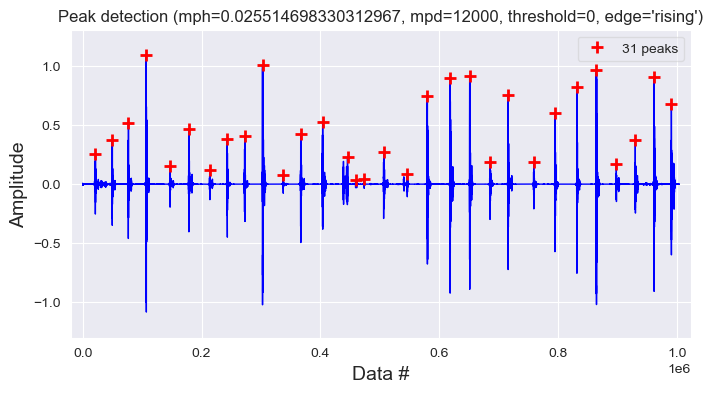

key 1 hp final k=0.5607	num_keys=31	peaks=31



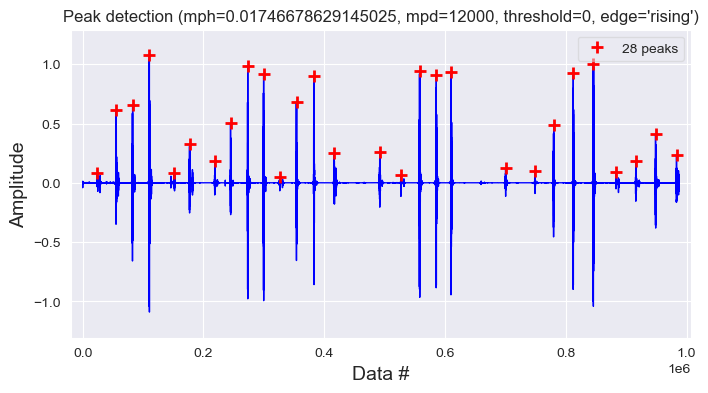

key 2 hp final k=0.6066	num_keys=28	peaks=28

key 3 hp final k=0.4187	num_keys=30	peaks=30

key 4 hp final k=0.3302	num_keys=30	peaks=30

key 5 hp final k=0.3681	num_keys=28	peaks=28

key 6 hp final k=0.3934	num_keys=27	peaks=27

key 7 hp final k=0.3373	num_keys=28	peaks=28

key 8 hp final k=0.3586	num_keys=29	peaks=29



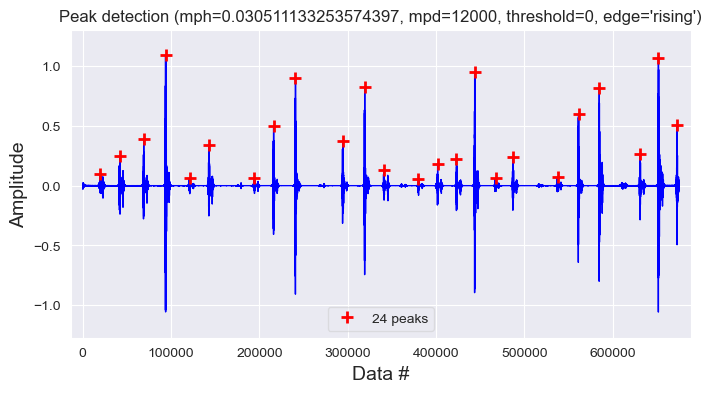

key 9 hp final k=0.3808	num_keys=24	peaks=24

key 0 hp final k=0.3413	num_keys=28	peaks=28

key Q hp final k=0.3373	num_keys=30	peaks=30



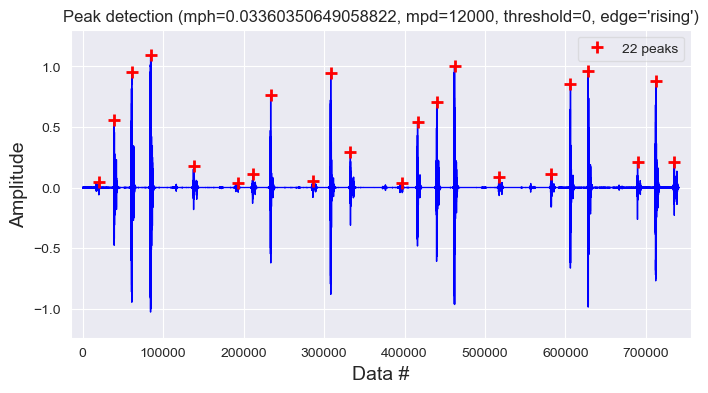

key W hp final k=0.5100	num_keys=22	peaks=22

key E hp final k=0.4187	num_keys=28	peaks=28

key R hp final k=0.4609	num_keys=25	peaks=25

key T hp final k=0.4272	num_keys=23	peaks=23

key Y hp final k=0.3681	num_keys=25	peaks=25

key U hp final k=0.3644	num_keys=24	peaks=24

key I hp final k=0.3871	num_keys=26	peaks=26

key O hp final k=0.3112	num_keys=29	peaks=29

key P hp final k=0.3207	num_keys=28	peaks=28

key A hp final k=0.4314	num_keys=29	peaks=29

key S hp final k=0.4955	num_keys=25	peaks=25

key D hp final k=0.4637	num_keys=29	peaks=29

key F hp final k=0.5000	num_keys=25	peaks=25

key G hp final k=0.4637	num_keys=24	peaks=24

key H hp final k=0.4356	num_keys=24	peaks=24

key J hp final k=0.4750	num_keys=26	peaks=26

key K hp final k=0.3586	num_keys=27	peaks=27

key L hp final k=0.5000	num_keys=23	peaks=23

key Z hp final k=0.4314	num_keys=22	peaks=22

key X hp final k=0.4416	num_keys=28	peaks=28

key C hp final k=0.4900	num_keys=27	peaks=27

key V hp final k=0.5062	num_keys=2

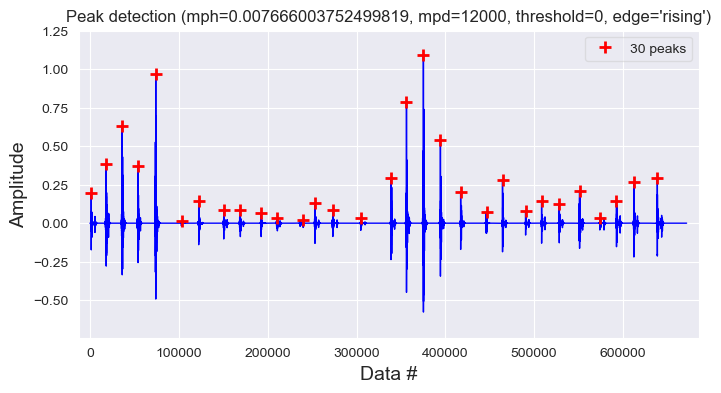

key 1 lenovo final k=0.4525	num_keys=30	peaks=30



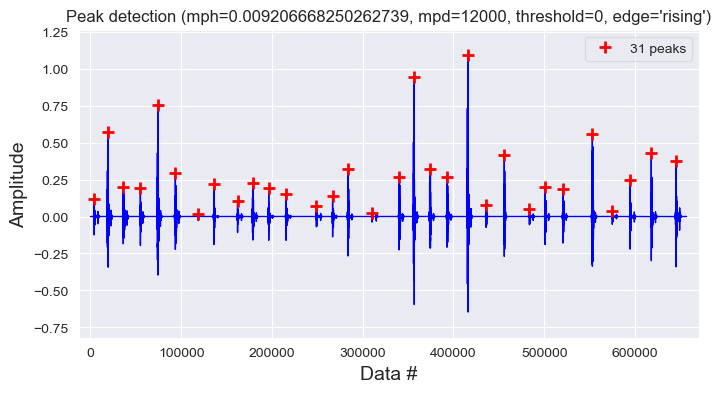

key 2 lenovo final k=0.5000	num_keys=31	peaks=31

key 3 lenovo final k=0.5000	num_keys=30	peaks=30

key 4 lenovo final k=0.5000	num_keys=30	peaks=30

key 5 lenovo final k=0.1609	num_keys=30	peaks=30

key 6 lenovo final k=0.5000	num_keys=31	peaks=31

key 7 lenovo final k=0.2834	num_keys=29	peaks=29

key 8 lenovo final k=0.3302	num_keys=27	peaks=27



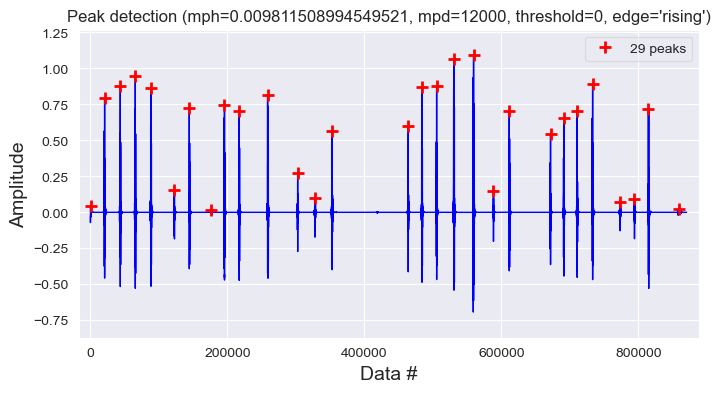

key 9 lenovo final k=0.3681	num_keys=29	peaks=29

key 0 lenovo final k=0.2922	num_keys=29	peaks=29

key Q lenovo final k=0.4750	num_keys=30	peaks=30



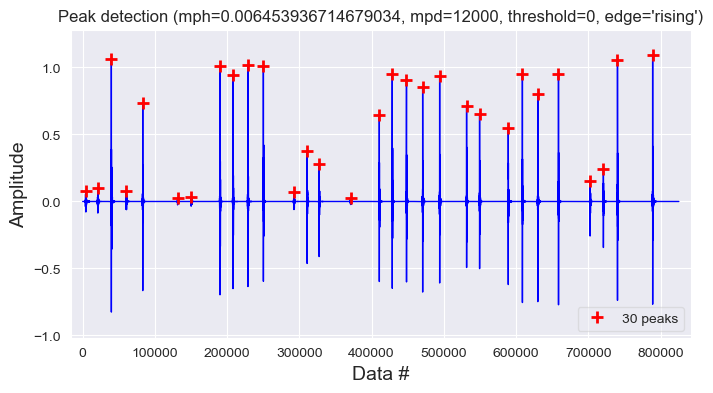

key W lenovo final k=0.4187	num_keys=30	peaks=30

key E lenovo final k=0.4187	num_keys=29	peaks=29

key R lenovo final k=0.3681	num_keys=30	peaks=30

key T lenovo final k=0.4750	num_keys=30	peaks=30

key Y lenovo final k=0.4525	num_keys=30	peaks=30

key U lenovo final k=0.5000	num_keys=30	peaks=30

key I lenovo final k=0.1925	num_keys=30	peaks=30

key O lenovo final k=0.5000	num_keys=30	peaks=30

key P lenovo final k=0.5000	num_keys=30	peaks=30

key A lenovo final k=0.4187	num_keys=30	peaks=30

key S lenovo final k=0.4750	num_keys=30	peaks=30

key D lenovo final k=0.3681	num_keys=30	peaks=30

key F lenovo final k=0.5000	num_keys=30	peaks=30

key G lenovo final k=0.2352	num_keys=30	peaks=30

key H lenovo final k=0.5000	num_keys=30	peaks=30

key J lenovo final k=0.5000	num_keys=30	peaks=30

key K lenovo final k=0.5000	num_keys=29	peaks=29

key L lenovo final k=0.4187	num_keys=29	peaks=29

key Z lenovo final k=0.4187	num_keys=28	peaks=28

key X lenovo final k=0.3681	num_keys=30	peaks=30



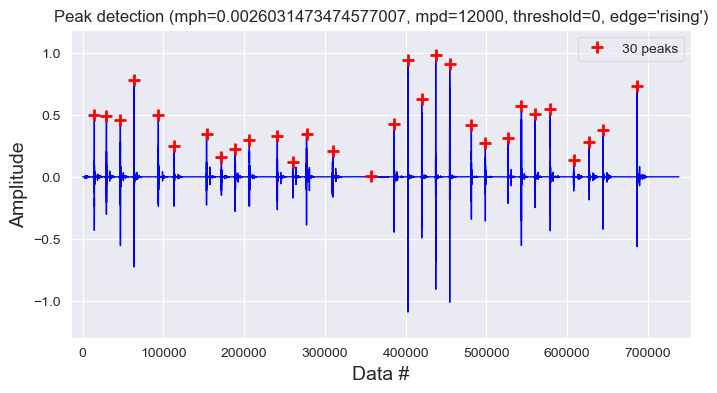

key 1 mac final k=0.2922	num_keys=30	peaks=30



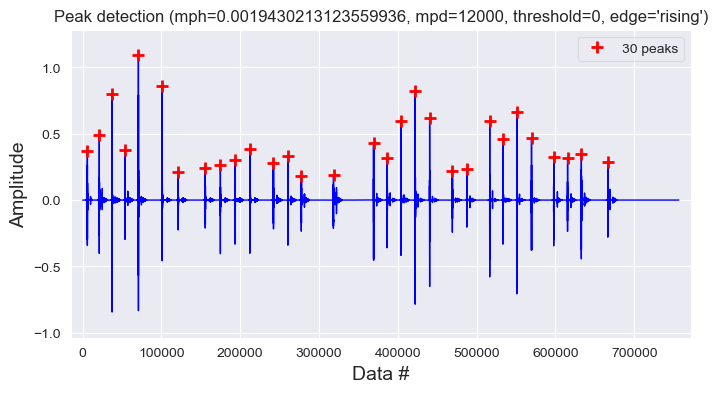

key 2 mac final k=0.6319	num_keys=30	peaks=30

key 3 mac final k=0.3302	num_keys=32	peaks=32

key 4 mac final k=0.9926	num_keys=31	peaks=31

key 5 mac final k=0.5000	num_keys=30	peaks=30

key 6 mac final k=0.5000	num_keys=31	peaks=31

key 7 mac final k=0.9926	num_keys=31	peaks=31

key 8 mac final k=0.6319	num_keys=30	peaks=30



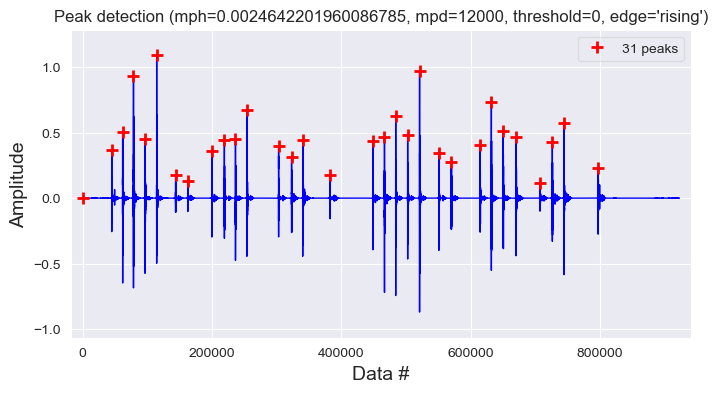

key 9 mac final k=0.7648	num_keys=31	peaks=31

key 0 mac final k=0.3207	num_keys=31	peaks=31

key Q mac final k=0.5000	num_keys=30	peaks=30



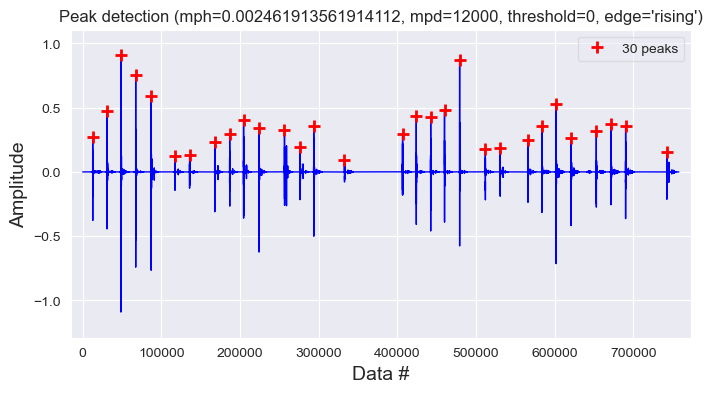

key W mac final k=1.4411	num_keys=30	peaks=30

key E mac final k=0.9926	num_keys=30	peaks=30

key R mac final k=0.5000	num_keys=30	peaks=30

key T mac final k=0.5000	num_keys=30	peaks=30

key Y mac final k=0.5000	num_keys=30	peaks=30

key U mac final k=0.5000	num_keys=29	peaks=29

key I mac final k=0.5475	num_keys=30	peaks=30

key O mac final k=0.5000	num_keys=30	peaks=30

key P mac final k=0.4187	num_keys=36	peaks=36

key A mac final k=0.5000	num_keys=30	peaks=30

key S mac final k=0.5000	num_keys=31	peaks=31

key D mac final k=1.1207	num_keys=29	peaks=29

key F mac final k=0.5000	num_keys=30	peaks=30

key G mac final k=0.5000	num_keys=30	peaks=30

key H mac final k=0.5000	num_keys=30	peaks=30

key J mac final k=0.5000	num_keys=30	peaks=30

key K mac final k=0.5000	num_keys=30	peaks=30

key L mac final k=0.5000	num_keys=29	peaks=29

key Z mac final k=0.5000	num_keys=30	peaks=30

key X mac final k=0.5000	num_keys=30	peaks=30

key C mac final k=0.5000	num_keys=30	peaks=30

key V mac fin

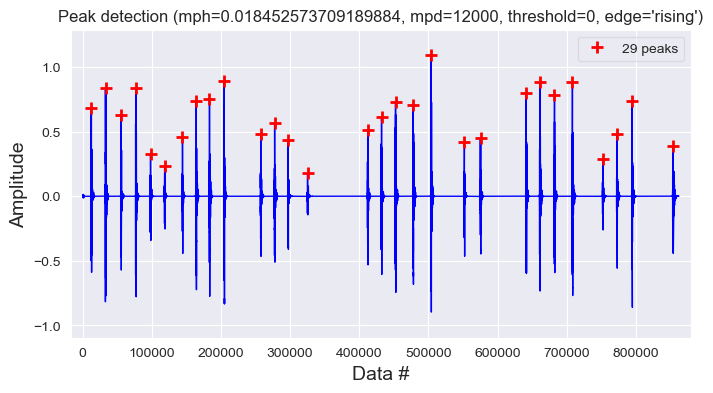

key 1 msi final k=0.5100	num_keys=29	peaks=29



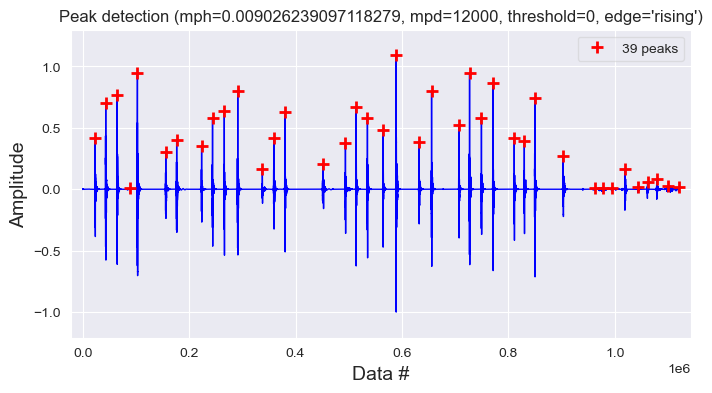

key 2 msi final k=0.2352	num_keys=39	peaks=39

key 3 msi final k=0.2779	num_keys=30	peaks=30

key 4 msi final k=0.2922	num_keys=29	peaks=29

key 5 msi final k=0.3373	num_keys=30	peaks=30

key 6 msi final k=0.2878	num_keys=29	peaks=29

key 7 msi final k=0.1487	num_keys=30	peaks=30

key 8 msi final k=0.2922	num_keys=29	peaks=29



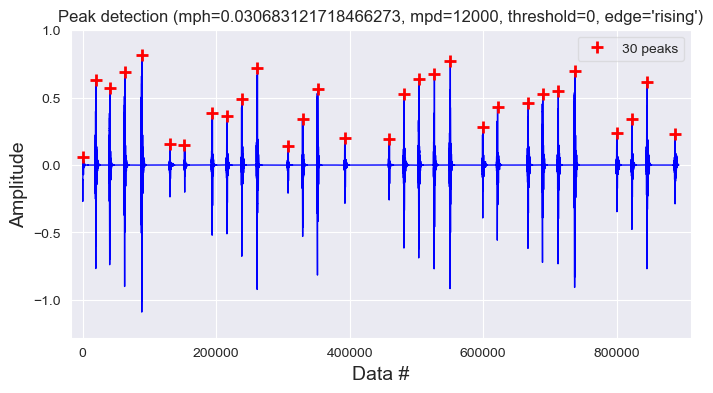

key 9 msi final k=0.1783	num_keys=30	peaks=30

key 0 msi final k=0.3990	num_keys=30	peaks=30

key Q msi final k=0.4446	num_keys=29	peaks=29



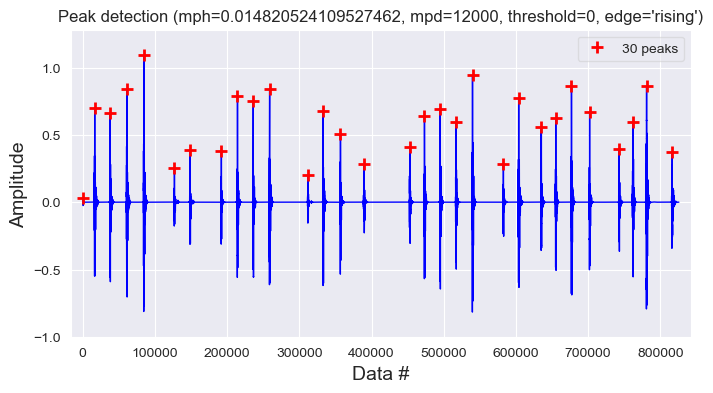

key W msi final k=0.4525	num_keys=30	peaks=30

key E msi final k=0.2459	num_keys=30	peaks=30

key R msi final k=0.3557	num_keys=29	peaks=29

key T msi final k=0.2922	num_keys=30	peaks=30

key Y msi final k=0.3871	num_keys=29	peaks=29

key U msi final k=0.4013	num_keys=29	peaks=29

key I msi final k=0.4089	num_keys=30	peaks=30

key O msi final k=0.4356	num_keys=29	peaks=29

key P msi final k=0.3919	num_keys=29	peaks=29

key A msi final k=0.2922	num_keys=30	peaks=30

key S msi final k=0.3934	num_keys=30	peaks=30

key D msi final k=0.2246	num_keys=30	peaks=30

key F msi final k=0.3413	num_keys=30	peaks=30

key G msi final k=0.3448	num_keys=30	peaks=30

key H msi final k=0.3867	num_keys=30	peaks=30

key J msi final k=0.2922	num_keys=29	peaks=29

key K msi final k=0.3586	num_keys=29	peaks=29

key L msi final k=0.3586	num_keys=30	peaks=30

key Z msi final k=0.2922	num_keys=29	peaks=29

key X msi final k=0.1925	num_keys=29	peaks=29

key C msi final k=0.2352	num_keys=30	peaks=30

key V msi fin

/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_11700/2596258967.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


In [167]:
# currently used keys
curr_keys = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM')
curr_keys.append("space")
curr_dataset = create_dataset(curr_keys, initial_k=0.5, key_length=12000)
print(curr_dataset)

In [169]:
# Read curr_dataset back from the file
# Write curr_dataset to a file to avoid running this shit over & over again
with open('curr_dataset.pkl', 'wb') as f:
    pickle.dump(curr_dataset, f)

with open('curr_dataset.pkl', 'rb') as f:
    curr_dataset = pickle.load(f)

In [170]:
curr_dataset

,Key,File
0,0,"[-0.00066189276, -0.00055819657, -0.0011301538..."
1,0,"[-0.005030811, -0.0048074424, -0.004878716, -0..."
2,0,"[-0.00063711096, -0.000562049, -0.00023142221,..."
3,0,"[-3.9930947e-06, 6.600186e-07, -7.560005e-06, ..."
4,0,"[-0.00011703188, 9.9015015e-05, 0.00012829664,..."
...,...,...
4302,36,"[-0.0001275256, -0.00013381263, -0.00013297707..."
4303,36,"[2.073219e-06, 7.830286e-06, 2.8897764e-06, 1...."
4304,36,"[-2.2005934e-05, -1.3029523e-05, -3.0114257e-0..."
4305,36,"[8.7648536e-05, 9.969589e-05, 8.79983e-05, 7.9..."


In [171]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [18]:
# def create_dataset(n_fft, hop_length, before, after, keys, audio_dir, curr_labels, prom=0.2391, original=True):
#     data_dict = {'Key':[], 'File':[]}
#     for i, File in enumerate(keys):
#         loc = audio_dir + File
#         samples, sr = librosa.load(loc)
#         show = (File[6 if original else 0] == '0')
#         strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, show)
#         if show:
#             print(f'Length strokes: {len(strokes)}')
#         label = [curr_labels[i]]*len(strokes)
#         data_dict['Key'] += label
#         data_dict['File'] += strokes
# 
#     df = pd.DataFrame(data_dict)
#     mapper = {}
#     counter = 0
#     for l in df['Key']:
#         if not l in mapper:
#             mapper[l] = counter
#             counter += 1
#     df.replace({'Key': mapper}, inplace = True)
#     
#     return df

In [148]:
import audiosegment

def get_audio_length(audio_path):
    audio = audiosegment.from_file(audio_path)
    return audio.duration_seconds

def convert_to_ms(t):
    return round(t*1000)

def get_audio_length_average(audio_path, keys):
    lengths = []
    for i, File in enumerate(keys):
        loc = audio_path + File
        length = get_audio_length(loc)
        print(f'File {loc} length: {length:2f}\n')
        lengths.append(length)
    average = np.mean(lengths)
    return convert_to_ms(average)

In [172]:
def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

def masking(samples):
    num_mask = 2
    freq_masking_max_percentage=0.10
    time_masking_max_percentage=0.10
    spec = samples
    mean_value = spec.mean()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
        freq_percentage = random.uniform(0.1, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = mean_value

        time_percentage = random.uniform(0.1, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = mean_value
    return spec

In [173]:
from skimage.transform import resize

class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


class ToMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')
        
        mfcc_spec = librosa.feature.mfcc(y=samples, sr=44100)
        mfcc_spec = np.transpose(mfcc_spec)
        return torch.tensor(mfcc_spec)


In [174]:
transform = Compose([ToMelSpectrogram(12000)])
transform_mfcc = Compose([ToMfcc(12000)])

In [175]:
audio_samples = curr_dataset['File'].values.tolist()
labels = curr_dataset['Key'].values.tolist()

audio_samples_new = audio_samples.copy() # audio samples CNN
print(len(audio_samples))

print(type(audio_samples[0]))

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])

# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

4307
<class 'numpy.ndarray'>
8614
8614


In [176]:
audioDatasetFin, audioDatasetFinMasking, audioDatasetMfcc, audioDatasetMfccMasking = [], [], [], []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])
    transformed_mfcc = transform_mfcc(audio_samples_new[i])
    
    # CoAtNet part
    audioDatasetFin.append((transformed_sample, labels[i]))
    audioDatasetFinMasking.append((masking(transformed_sample), labels[i]))
    
    # masking part
    audioDatasetMfcc.append((transformed_sample, transformed_mfcc, labels[i]))
    audioDatasetMfccMasking.append((masking(transformed_sample), transformed_mfcc, labels[i]))


In [177]:
mel_spec = librosa.feature.melspectrogram(y=audio_samples[i], sr=44100, n_mels=64, n_fft=1024, hop_length=225)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max))
print(labels[i])

IndexError: list index out of range

In [178]:
# check for lengths of datasets
len(audioDatasetMfcc), len(audioDatasetMfcc + audioDatasetMfccMasking), len(audioDatasetFin), len(audioDatasetFin + audioDatasetFinMasking)

(8614, 17228, 8614, 17228)

In [179]:
import time
from sklearn.base import BaseEstimator

class MfccLSTM(nn.Module, BaseEstimator):
    def __init__(self, batch_size=16, num_epochs=500, patience=120):
        super(MfccLSTM, self).__init__()        
        self.num_epochs = num_epochs
        self.patience = patience
        self.batch_size = batch_size
        
        hidden_size = 32
        input_size = 20
        dropout = 0.2 
        num_classes = 36
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.LazyLinear(128)
        self.final_lstm = nn.LSTM(1, 128, batch_first=True, proj_size=64)
        
        self.fc = nn.LazyLinear(num_classes)
    
    def forward(self, images, sequences):
        # must return shape (batch_size, num_classes) 
        # batch_size: right now is 16
        # num_classes: right now is 36
        x1 = self.conv(images)
        # print(f'input of first lstm: {sequences.shape[1:]}')
        out1, _ = self.lstm(sequences)
        out1_dp = self.dropout(out1)
        # print(f'output of first lstm: {out1_dp.shape[1:]}')
        # print(f'input of second lstm: {out1_dp[:, -1, :].shape[1:]}')
        out2, _ = self.lstm2(out1_dp[:, -1, :])
        out2_dp = self.dropout(out2)
        # print(f'output of second lstm: {out2_dp.shape[1:]}')
        x2 = self.fc2(self.fc1(out2_dp))
        x3 = torch.cat((x1, x2), 1)
        # print(f'output of concatenation: {x3.shape[1:]}')
        # x4 = self.fc3(x3)
        # # print(f'input final lstm: {x4[:,-1,:].shape[1:]}')
        # print(f'x4.shape: {x4.shape[1:]}')
        # x_final = self.final_lstm(x4)
        # # x = self.fc(final_out[:, -1, :])
        x = self.fc(x3)
        return x
    
    def fit(self, X, y):
        self._optimizer = optim.Adam(self.parameters(), lr=5e-4)
        # same training method but now inside the class
        model = self.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        # # concatenate so it has the same shape as before
        # dataset = np.concatenate((X, y), axis=1)
         # concatenate so it has the same shape as before
        dataset = [(X[i], y[i]) for i in range(len(X))]
        train_set, val_set = train_test_split(dataset, test_size=0.005)
        train_loader = DataLoader(train_set, batch_size=self.batch_size)
        val_loader = DataLoader(val_set, batch_size=self.batch_size)
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for (images, sequences), labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for (images, sequences), labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
        
                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 1 == 0:
                print(f"Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
        
        
    def predict(self, X):
        argnames=["images", "sequences"]
        fin_dict = {}
        # create the list with each of the ith range tuples
        for i in range(len(X[0])-1):
            fin_dict[argnames[i]] = [torch.tensor(t[i]) for t in dataset]

        # torch.stack each one of the lists
        for key in fin_dict.keys():
            fin_dict[key] = torch.stack(fin_dict[key]).to(device)
        
        images = [tup[0] for tup in X]
        sequences = [tup[1] for tup in X]
        images_torch, sequences_torch = torch.tensor(np.array(images)).to(device), torch.tensor(np.array(sequences)).to(device)
        # model specifying
        model = self.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(images_torch, sequences_torch)
            _, predicted = torch.max(outputs.data, 1)
        
        pred = []
        # phrase = predicted.tolist()
        # for i in range(len(phrase)):
        #     pred.append(self.keys[phrase[i]])
        # 
        # pred_df = pd.DataFrame(pred)
        # return np.squeeze(pred_df.to_numpy().T)
        return predicted.tolist()

In [186]:
from coatnet import CoAtNet as CoAtNetImp
num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

class CoAtNet(nn.Module, BaseEstimator):
    def __init__(self, num_epochs=700, patience=200, keys='1234567890QWERTYUIOPASDFGHJKLZXCVBNM'):
        super(CoAtNet, self).__init__()    
        self.keys = keys
        self.model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(self.keys))
        self.num_epochs = num_epochs
        self.patience = patience
    
    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, y):
        # concatenate so it has the same shape as before
        dataset = [(X[i], y[i]) for i in range(np.array(X).shape[0])]
        # dataset = np.concatenate((X, y), axis=1)
        train_set, val_set = train_test_split(dataset, test_size=0.005)
        train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)

        # Initialize model, optimizer, and loss function
        self._optimizer = optim.Adam(self.model.parameters(), lr=5e-4)

        # same training method but now inside the class
        model = self.model.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
        
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 1 == 0:
                print(f"Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
    
    def predict(self, X):
        argnames=["x"]
        fin_dict = {}
        # create the list with each of the ith range tuples
        for i in range(len(X[0])-1):
            fin_dict[argnames[i]] = [t[i] for t in dataset]
            
        # torch.stack each one of the lists
        for key in fin_dict.keys():
            fin_dict[key] = torch.stack(fin_dict[key]).to(device)
        
        X = torch.tensor(np.array(X)).to(device)
        
        # model specifying
        model = self.model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
        
        pred = []
        # phrase = predicted.tolist()
        # for i in range(len(phrase)):
        #     pred.append(self.keys[phrase[i]])
        # 
        # pred_df = pd.DataFrame(pred)
        # return np.squeeze(pred_df.to_numpy().T)
        return predicted.tolist()

In [187]:
from sklearn.metrics import precision_score, recall_score, f1_score
N_SPLITS = 8
kf = KFold(n_splits=N_SPLITS, shuffle=True)
fold_results = []
accuracies, recalls, precisions, f1_scores = [], [], [], []

dataset = audio_samples_new
coatnet = True

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)): 
    print(f'Fold {fold+1}/{N_SPLITS}')
    train_set = Subset(dataset, train_idx)
    labels_train_set = Subset(labels, train_idx)
    test_set = Subset(dataset, val_idx)
    labels_test_set = Subset(labels, val_idx)
    final_train_set = []
    if coatnet:
        model = CoAtNet(keys=curr_keys)
        for i in range(len(train_set)):
            transformed_sample = transform(train_set[i])
            final_train_set.append((transformed_sample, labels_train_set[i]))
            X_train = [t[0] for t in final_train_set]
            y_train = [t[1] for t in final_train_set]
    else:
        model = MfccLSTM()
        for i in range(len(train_set)):
            transformed_mfcc = transform_mfcc(train_set[i])
            transformed_sample = transform(train_set[i])
            final_train_set.append((transformed_sample, transformed_mfcc, labels_train_set[i]))
            final_train_set.append((masking(transformed_sample), transformed_mfcc, labels_train_set[i]))
            X_train = [(t[0],t[1]) for t in final_train_set]
            y_train = [t[2] for t in final_train_set]
    model.fit(X_train, y_train)
    
    if coatnet:
        final_test_set = []
        for i in range(len(test_set)):
            transformed_sample = transform(test_set[i])
            final_test_set.append((transformed_sample, labels_test_set[i]))
        X_test = [t[0] for t in final_test_set]
        y_test = [t[1] for t in final_test_set]
        prediction = model.predict(X_test)
    else: 
        final_test_set = []
        for i in range(len(test_set)):
            transformed_mfcc = transform_mfcc(test_set[i])
            transformed_sample = transform(test_set[i])
            final_test_set.append((transformed_sample, transformed_mfcc, labels_test_set[i]))
        X_test = [(t[0],t[1]) for t in final_test_set]
        y_test = [t[2] for t in final_test_set]
        prediction = model.predict(X_test)
    
    print(f'prediction: {prediction[:20]}')
    print(f'true labels: {y_test[:20]}')
    
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='macro')  # For binary classification
    recall = recall_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    
    print(f'Fold {fold+1} FINAL RESULTS: ')
    print(f'accuracy: {accuracy:.3f} // precision: {precision:.3f} // recall: {recall:.3f} // f1: {f1:.3f}\n')
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    
print(f'\nAverage accuracy: {np.mean(accuracies):.3f}')
print(f'Average precision: {np.mean(precisions):.3f}')
print(f'Average recall: {np.mean(recalls):.3f}')
print(f'Average f1: {np.mean(f1_scores):.3f}')

Fold 1/8


KeyboardInterrupt: 

In [94]:
from sklearn.metrics import make_scorer

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X = [(t[0],t[1]) for t in audioDatasetMfcc]
X_masking = [(t[0],t[1]) for t in audioDatasetMfccMasking]
y = [t[2] for t in audioDatasetMfcc]
y_masking = [t[2] for t in audioDatasetMfccMasking]

model = MfccLSTM()

param_grid = {
    'patience': [120],
    'batch_size': [32],
}


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
}
# 
grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# # model = CoAtNet(patience=1)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.01)
grid_search.fit(X + X_masking, y + y_masking)
# print(len(X))
# model.fit(X+X_masking, y+y_masking)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch [1/500], Train Loss: 3.3822, Train Accuracy: 0.0968, Val Accuracy: 0.1618, Iter Time: 2.14s
Epoch [2/500], Train Loss: 2.7274, Train Accuracy: 0.2369, Val Accuracy: 0.2543, Iter Time: 1.68s
Epoch [3/500], Train Loss: 2.1223, Train Accuracy: 0.3977, Val Accuracy: 0.3295, Iter Time: 1.87s
Epoch [4/500], Train Loss: 1.6092, Train Accuracy: 0.5482, Val Accuracy: 0.4624, Iter Time: 2.08s
Epoch [5/500], Train Loss: 1.2074, Train Accuracy: 0.6673, Val Accuracy: 0.5434, Iter Time: 1.64s
Epoch [6/500], Train Loss: 0.9655, Train Accuracy: 0.7332, Val Accuracy: 0.5665, Iter Time: 1.62s
Epoch [7/500], Train Loss: 0.7799, Train Accuracy: 0.7894, Val Accuracy: 0.6994, Iter Time: 1.53s
Epoch [8/500], Train Loss: 0.5831, Train Accuracy: 0.8471, Val Accuracy: 0.7110, Iter Time: 1.69s
Epoch [9/500], Train Loss: 0.5065, Train Accuracy: 0.8748, Val Accuracy: 0.6474, Iter Time: 1.71s
Epoch [10/500], Train Loss: 0.4588, Train Accuracy: 0.8776

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3225, Train Accuracy: 0.1093, Val Accuracy: 0.1792, Iter Time: 1.41s
Epoch [2/500], Train Loss: 2.6485, Train Accuracy: 0.2790, Val Accuracy: 0.2832, Iter Time: 1.47s
Epoch [3/500], Train Loss: 2.0451, Train Accuracy: 0.4252, Val Accuracy: 0.3699, Iter Time: 1.56s
Epoch [4/500], Train Loss: 1.5517, Train Accuracy: 0.5479, Val Accuracy: 0.4335, Iter Time: 1.51s
Epoch [5/500], Train Loss: 1.2108, Train Accuracy: 0.6548, Val Accuracy: 0.4971, Iter Time: 1.69s
Epoch [6/500], Train Loss: 0.9799, Train Accuracy: 0.7299, Val Accuracy: 0.5029, Iter Time: 1.60s
Epoch [7/500], Train Loss: 0.8193, Train Accuracy: 0.7753, Val Accuracy: 0.5723, Iter Time: 1.63s
Epoch [8/500], Train Loss: 0.7151, Train Accuracy: 0.8010, Val Accuracy: 0.6012, Iter Time: 1.43s
Epoch [9/500], Train Loss: 0.5866, Train Accuracy: 0.8358, Val Accuracy: 0.6185, Iter Time: 1.59s
Epoch [10/500], Train Loss: 0.5285, Train Accuracy: 0.8626, Val Accuracy: 0.6532, Iter Time: 1.58s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3107, Train Accuracy: 0.1114, Val Accuracy: 0.1618, Iter Time: 1.38s
Epoch [2/500], Train Loss: 2.6207, Train Accuracy: 0.2591, Val Accuracy: 0.2890, Iter Time: 1.56s
Epoch [3/500], Train Loss: 2.0468, Train Accuracy: 0.4205, Val Accuracy: 0.3064, Iter Time: 1.65s
Epoch [4/500], Train Loss: 1.5691, Train Accuracy: 0.5508, Val Accuracy: 0.4624, Iter Time: 1.60s
Epoch [5/500], Train Loss: 1.2148, Train Accuracy: 0.6491, Val Accuracy: 0.4682, Iter Time: 1.58s
Epoch [6/500], Train Loss: 0.9851, Train Accuracy: 0.7284, Val Accuracy: 0.5780, Iter Time: 1.75s
Epoch [7/500], Train Loss: 0.8196, Train Accuracy: 0.7662, Val Accuracy: 0.5723, Iter Time: 1.49s
Epoch [8/500], Train Loss: 0.6875, Train Accuracy: 0.8068, Val Accuracy: 0.5954, Iter Time: 1.68s
Epoch [9/500], Train Loss: 0.5980, Train Accuracy: 0.8438, Val Accuracy: 0.6763, Iter Time: 1.49s
Epoch [10/500], Train Loss: 0.5087, Train Accuracy: 0.8584, Val Accuracy: 0.6763, Iter Time: 1.67s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.2900, Train Accuracy: 0.1099, Val Accuracy: 0.1387, Iter Time: 1.39s
Epoch [2/500], Train Loss: 2.5816, Train Accuracy: 0.2762, Val Accuracy: 0.2486, Iter Time: 1.61s
Epoch [3/500], Train Loss: 2.0194, Train Accuracy: 0.4303, Val Accuracy: 0.3353, Iter Time: 1.65s
Epoch [4/500], Train Loss: 1.5828, Train Accuracy: 0.5532, Val Accuracy: 0.4624, Iter Time: 1.68s
Epoch [5/500], Train Loss: 1.2722, Train Accuracy: 0.6469, Val Accuracy: 0.5145, Iter Time: 1.78s
Epoch [6/500], Train Loss: 0.9727, Train Accuracy: 0.7342, Val Accuracy: 0.5491, Iter Time: 1.74s
Epoch [7/500], Train Loss: 0.8286, Train Accuracy: 0.7836, Val Accuracy: 0.5607, Iter Time: 1.63s
Epoch [8/500], Train Loss: 0.6894, Train Accuracy: 0.8206, Val Accuracy: 0.6069, Iter Time: 1.71s
Epoch [9/500], Train Loss: 0.6475, Train Accuracy: 0.8303, Val Accuracy: 0.6647, Iter Time: 1.75s
Epoch [10/500], Train Loss: 0.5270, Train Accuracy: 0.8624, Val Accuracy: 0.7052, Iter Time: 1.67s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.2814, Train Accuracy: 0.1230, Val Accuracy: 0.1618, Iter Time: 1.45s
Epoch [2/500], Train Loss: 2.5681, Train Accuracy: 0.2872, Val Accuracy: 0.2312, Iter Time: 1.71s
Epoch [3/500], Train Loss: 1.8809, Train Accuracy: 0.4580, Val Accuracy: 0.3873, Iter Time: 1.71s
Epoch [4/500], Train Loss: 1.3512, Train Accuracy: 0.5981, Val Accuracy: 0.4855, Iter Time: 1.46s
Epoch [5/500], Train Loss: 1.0572, Train Accuracy: 0.6933, Val Accuracy: 0.5202, Iter Time: 1.48s
Epoch [6/500], Train Loss: 0.8506, Train Accuracy: 0.7571, Val Accuracy: 0.5202, Iter Time: 1.67s
Epoch [7/500], Train Loss: 0.7351, Train Accuracy: 0.7989, Val Accuracy: 0.5780, Iter Time: 1.68s
Epoch [8/500], Train Loss: 0.6033, Train Accuracy: 0.8367, Val Accuracy: 0.6243, Iter Time: 1.66s
Epoch [9/500], Train Loss: 0.5028, Train Accuracy: 0.8660, Val Accuracy: 0.5376, Iter Time: 1.60s
Epoch [10/500], Train Loss: 0.4251, Train Accuracy: 0.8853, Val Accuracy: 0.6532, Iter Time: 1.81s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3248, Train Accuracy: 0.1035, Val Accuracy: 0.1214, Iter Time: 1.42s
Epoch [2/500], Train Loss: 2.6451, Train Accuracy: 0.2674, Val Accuracy: 0.1965, Iter Time: 1.60s
Epoch [3/500], Train Loss: 2.0356, Train Accuracy: 0.4133, Val Accuracy: 0.3121, Iter Time: 1.67s
Epoch [4/500], Train Loss: 1.5855, Train Accuracy: 0.5559, Val Accuracy: 0.4104, Iter Time: 1.67s
Epoch [5/500], Train Loss: 1.2247, Train Accuracy: 0.6548, Val Accuracy: 0.4393, Iter Time: 1.75s
Epoch [6/500], Train Loss: 1.0116, Train Accuracy: 0.7280, Val Accuracy: 0.4855, Iter Time: 1.75s
Epoch [7/500], Train Loss: 0.8353, Train Accuracy: 0.7741, Val Accuracy: 0.6416, Iter Time: 1.80s
Epoch [8/500], Train Loss: 0.6574, Train Accuracy: 0.8245, Val Accuracy: 0.6416, Iter Time: 1.80s
Epoch [9/500], Train Loss: 0.5788, Train Accuracy: 0.8495, Val Accuracy: 0.6763, Iter Time: 1.89s
Epoch [10/500], Train Loss: 0.5315, Train Accuracy: 0.8651, Val Accuracy: 0.6705, Iter Time: 1.74s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3018, Train Accuracy: 0.1148, Val Accuracy: 0.1676, Iter Time: 1.39s
Epoch [2/500], Train Loss: 2.6261, Train Accuracy: 0.2625, Val Accuracy: 0.2601, Iter Time: 1.47s
Epoch [3/500], Train Loss: 2.0441, Train Accuracy: 0.4200, Val Accuracy: 0.3064, Iter Time: 1.68s
Epoch [4/500], Train Loss: 1.5231, Train Accuracy: 0.5534, Val Accuracy: 0.4393, Iter Time: 1.54s
Epoch [5/500], Train Loss: 1.1813, Train Accuracy: 0.6596, Val Accuracy: 0.4971, Iter Time: 1.76s
Epoch [6/500], Train Loss: 0.9440, Train Accuracy: 0.7357, Val Accuracy: 0.5607, Iter Time: 1.72s
Epoch [7/500], Train Loss: 0.7925, Train Accuracy: 0.7848, Val Accuracy: 0.5896, Iter Time: 1.53s
Epoch [8/500], Train Loss: 0.7015, Train Accuracy: 0.8129, Val Accuracy: 0.6301, Iter Time: 1.66s
Epoch [9/500], Train Loss: 0.5765, Train Accuracy: 0.8428, Val Accuracy: 0.5838, Iter Time: 1.77s
Epoch [10/500], Train Loss: 0.5241, Train Accuracy: 0.8584, Val Accuracy: 0.6416, Iter Time: 1.63s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3148, Train Accuracy: 0.1141, Val Accuracy: 0.1792, Iter Time: 1.41s
Epoch [2/500], Train Loss: 2.5700, Train Accuracy: 0.2865, Val Accuracy: 0.3353, Iter Time: 1.54s
Epoch [3/500], Train Loss: 1.7919, Train Accuracy: 0.4709, Val Accuracy: 0.4104, Iter Time: 1.72s
Epoch [4/500], Train Loss: 1.3751, Train Accuracy: 0.5902, Val Accuracy: 0.3931, Iter Time: 1.58s
Epoch [5/500], Train Loss: 1.1210, Train Accuracy: 0.6689, Val Accuracy: 0.5202, Iter Time: 1.74s
Epoch [6/500], Train Loss: 0.9168, Train Accuracy: 0.7360, Val Accuracy: 0.5260, Iter Time: 1.60s
Epoch [7/500], Train Loss: 0.7288, Train Accuracy: 0.7934, Val Accuracy: 0.6185, Iter Time: 1.64s
Epoch [8/500], Train Loss: 0.5595, Train Accuracy: 0.8489, Val Accuracy: 0.6358, Iter Time: 1.70s
Epoch [9/500], Train Loss: 0.4780, Train Accuracy: 0.8718, Val Accuracy: 0.6301, Iter Time: 1.61s
Epoch [10/500], Train Loss: 0.4695, Train Accuracy: 0.8804, Val Accuracy: 0.5954, Iter Time: 1.70s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3455, Train Accuracy: 0.1001, Val Accuracy: 0.1792, Iter Time: 1.43s
Epoch [2/500], Train Loss: 2.7290, Train Accuracy: 0.2374, Val Accuracy: 0.2775, Iter Time: 1.70s
Epoch [3/500], Train Loss: 2.1404, Train Accuracy: 0.3875, Val Accuracy: 0.3815, Iter Time: 2.15s
Epoch [4/500], Train Loss: 1.5966, Train Accuracy: 0.5407, Val Accuracy: 0.4971, Iter Time: 1.68s
Epoch [5/500], Train Loss: 1.1800, Train Accuracy: 0.6637, Val Accuracy: 0.5665, Iter Time: 1.78s
Epoch [6/500], Train Loss: 0.9701, Train Accuracy: 0.7293, Val Accuracy: 0.6243, Iter Time: 2.18s
Epoch [7/500], Train Loss: 0.7830, Train Accuracy: 0.7815, Val Accuracy: 0.6416, Iter Time: 1.72s
Epoch [8/500], Train Loss: 0.6764, Train Accuracy: 0.8126, Val Accuracy: 0.6243, Iter Time: 1.67s
Epoch [9/500], Train Loss: 0.5675, Train Accuracy: 0.8493, Val Accuracy: 0.6763, Iter Time: 2.10s
Epoch [10/500], Train Loss: 0.4881, Train Accuracy: 0.8651, Val Accuracy: 0.6879, Iter Time: 1.61s
Epoch [11/500], Tra

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/500], Train Loss: 3.3243, Train Accuracy: 0.1041, Val Accuracy: 0.1329, Iter Time: 1.40s
Epoch [2/500], Train Loss: 2.6241, Train Accuracy: 0.2554, Val Accuracy: 0.2775, Iter Time: 1.70s
Epoch [3/500], Train Loss: 1.9605, Train Accuracy: 0.4327, Val Accuracy: 0.4104, Iter Time: 1.61s
Epoch [4/500], Train Loss: 1.4195, Train Accuracy: 0.5944, Val Accuracy: 0.4682, Iter Time: 1.62s
Epoch [5/500], Train Loss: 1.0939, Train Accuracy: 0.7046, Val Accuracy: 0.5087, Iter Time: 1.75s
Epoch [6/500], Train Loss: 0.9155, Train Accuracy: 0.7428, Val Accuracy: 0.5549, Iter Time: 1.72s
Epoch [7/500], Train Loss: 0.7772, Train Accuracy: 0.7818, Val Accuracy: 0.5607, Iter Time: 1.68s
Epoch [8/500], Train Loss: 0.6593, Train Accuracy: 0.8145, Val Accuracy: 0.5723, Iter Time: 1.72s
Epoch [9/500], Train Loss: 0.5614, Train Accuracy: 0.8508, Val Accuracy: 0.6358, Iter Time: 1.77s
Epoch [10/500], Train Loss: 0.4779, Train Accuracy: 0.8727, Val Accuracy: 0.6994, Iter Time: 1.64s
Epoch [11/500], Tra

GridSearchCV(cv=5, estimator=MfccLSTM(),
             param_grid={'batch_size': [32], 'patience': [120, 150]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1_weighted': make_scorer(f1_score, response_method='predict', average=weighted, zero_division=0.0),
                      'precision_weighted': make_scorer(precision_score, response_method='predict', average=weighted, zero_division=0.0),
                      'recall_weighted': make_scorer(recall_score, response_method='predict', average=weighted, zero_division=0.0)},
             verbose=3)

In [95]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

grid_search.cv_results_

Rank: 1
Params: {'batch_size': 32, 'patience': 120}
Test accuracy: 0.901 / F1 Weighted: 0.913 / Recall Weighted: 0.901 / Precision Weighted: 0.931

Rank: 2
Params: {'batch_size': 32, 'patience': 150}
Test accuracy: 0.872 / F1 Weighted: 0.884 / Recall Weighted: 0.872 / Precision Weighted: 0.912



{'mean_fit_time': array([ 358.92505903, 6382.50409656]),
 'std_fit_time': array([  21.37275194, 7360.0111818 ]),
 'mean_score_time': array([0.27871819, 0.28930235]),
 'std_score_time': array([0.04145276, 0.03317735]),
 'param_batch_size': masked_array(data=[32, 32],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_patience': masked_array(data=[120, 150],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 32, 'patience': 120},
  {'batch_size': 32, 'patience': 150}],
 'split0_test_accuracy': array([0.90034762, 0.90498262]),
 'split1_test_accuracy': array([0.89687138, 0.88760139]),
 'split2_test_accuracy': array([0.89907193, 0.91647332]),
 'split3_test_accuracy': array([0.90603248, 0.88979118]),
 'split4_test_accuracy': array([0.9025522 , 0.76218097]),
 'mean_test_accuracy': array([0.90097512, 0.8722059 ]),
 'std_test_accuracy': array([0.00312796, 0.05601012]),
 'rank_test_accuracy

In [36]:
from sklearn.metrics import make_scorer

dataset = audioDatasetFin + audioDatasetFinMasking
X = [t[0] for t in audioDatasetFin]
X_masking = [t[0] for t in audioDatasetFinMasking]
y = [t[1] for t in audioDatasetFin]
y_masking = [t[1] for t in audioDatasetFinMasking]
print(np.array(X).shape)
# first_el = dataset[0][0]
print(np.array(y+y_masking).shape)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

param_grid = {
    'num_epochs': [500],
    # 'patience': [55, 75, 100],
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# model = CoAtNet(patience=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.01)
grid_search.fit(X_train + X_masking, y_train + y_masking)
# grid_search.fit(X_train, y_train)
# grid_search.fit(X, y)
# print(np.array(X_train).shape)
# print(np.array(y_train).shape)
# print(np.array(dataset).shape)
# print(np.concatenate((X_train, y_train), axis=3).shape)
# model.fit(X_train+X_masking, y_train+y_masking)
# print(f'Prediction: {model.predict(np.array(X_test)).shape}')
# final_labels_set = [original_set[ind] for ind in y_test]
# print(f'Labels: {np.array(final_labels_set).shape}')

(1078, 1, 64, 64)
(2156,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [1/500], Train Loss: 4.4235, Train Accuracy: 0.0313, Val Accuracy: 0.0000, Iter Time: 6.24s
Epoch [2/500], Train Loss: 3.8723, Train Accuracy: 0.0417, Val Accuracy: 0.0000, Iter Time: 5.31s
Epoch [3/500], Train Loss: 3.7498, Train Accuracy: 0.0448, Val Accuracy: 0.0000, Iter Time: 5.29s
Epoch [4/500], Train Loss: 3.6533, Train Accuracy: 0.0663, Val Accuracy: 0.0233, Iter Time: 5.31s
Epoch [5/500], Train Loss: 3.4700, Train Accuracy: 0.1092, Val Accuracy: 0.0465, Iter Time: 5.31s
Epoch [6/500], Train Loss: 3.2137, Train Accuracy: 0.1571, Val Accuracy: 0.0930, Iter Time: 5.31s
Epoch [7/500], Train Loss: 2.8897, Train Accuracy: 0.2399, Val Accuracy: 0.1744, Iter Time: 5.30s
Epoch [8/500], Train Loss: 2.5331, Train Accuracy: 0.3319, Val Accuracy: 0.2442, Iter Time: 5.31s
Epoch [9/500], Train Loss: 2.1194, Train Accuracy: 0.4301, Val Accuracy: 0.3140, Iter Time: 5.31s
Epoch [10/500], Train Loss: 1.771

GridSearchCV(cv=5, estimator=CoAtNet(), param_grid={'num_epochs': [500]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1_weighted': make_scorer(f1_score, response_method='predict', average=weighted, zero_division=0.0),
                      'precision_weighted': make_scorer(precision_score, response_method='predict', average=weighted, zero_division=0.0),
                      'recall_weighted': make_scorer(recall_score, response_method='predict', average=weighted, zero_division=0.0)},
             verbose=3)

In [89]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

grid_search.cv_results_

Rank: 1
Params: {'batch_size': 32, 'num_epochs': 500}
Test accuracy: 0.905 / F1 Weighted: 0.913 / Recall Weighted: 0.905 / Precision Weighted: 0.926

Rank: 2
Params: {'batch_size': 16, 'num_epochs': 500}
Test accuracy: 0.831 / F1 Weighted: 0.853 / Recall Weighted: 0.831 / Precision Weighted: 0.905



{'mean_fit_time': array([361.54972377, 357.6851572 ]),
 'std_fit_time': array([ 57.41657398, 269.66396278]),
 'mean_score_time': array([0.28583179, 0.29486952]),
 'std_score_time': array([0.07177304, 0.05479428]),
 'param_batch_size': masked_array(data=[16, 32],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_num_epochs': masked_array(data=[500, 500],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 16, 'num_epochs': 500},
  {'batch_size': 32, 'num_epochs': 500}],
 'split0_test_accuracy': array([0.88760139, 0.90382387]),
 'split1_test_accuracy': array([0.85168019, 0.90150637]),
 'split2_test_accuracy': array([0.6612529, 0.9187935]),
 'split3_test_accuracy': array([0.84454756, 0.89327146]),
 'split4_test_accuracy': array([0.91067285, 0.90719258]),
 'mean_test_accuracy': array([0.83115098, 0.90491756]),
 'std_test_accuracy': array([0.08829117, 0.00832083]),
 'rank_test_accuracy

In [ ]:
# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df = cv_results_df[["params", "mean_test_accuracy", "rank_test_accuracy", "mean_test_f1_weighted", "rank_test_f1_weighted", "mean_test_precision_weighted", "rank_test_precision_weighted", 
#  "mean_test_recall_weighted", "rank_test_recall_weighted"]]
# cv_results_df

# param_grid = {
#     'num_epochs': [500, 700, 1100],
#     'patience': [55, 75, 100],
# }
# 
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
#     'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
#     'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
# }
# 
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# grid_search.fit(X, y)
# param_grid = {
#     'num_epochs': [500, 700, 1100],
#     # 'patience': [10, 15, 20, 30, 50, 100],
# }
# grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False, verbose)
# 
# dataset = audioDatasetMfcc + audioDatasetMfccMasking
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# # print(X_train.shape)
# grid_search.fit(X_train, y_train)

In [ ]:
sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

# best_params_list = grid_search.cv_results_['rank_test_accuracy']
# print(grid_search.cv_results_)
# print(best_params_list)
# print(best_params_list)
# print(best_params_list)
# print(grid_search.cv_results_["mean_test_accuracy"])
# 
# for i in best_params_list:
#     print(f'Parameter {i-1}: {grid_search.cv_results_["params"][i-1]}')
#     print(f'Mean Test accuracy: {grid_search.cv_results_["mean_test_accuracy"][i-1]:.3f}')
#     print(f'Std Test accuracy: {grid_search.cv_results_["std_test_accuracy"][i-1]:.3f}')
#     # print(f'Mean F1 weighted: {grid_search.cv_results_["mean_test_f1_weighted"][i-1]:.3f}')
#     # print(f'Mean Recall weighted: {grid_search.cv_results_["mean_test_recall_weighted"][i-1]:.3f}')
#     # print(f'Mean Precision weighted: {grid_search.cv_results_["mean_test_precision_weighted"][i-1]:.3f}')
#     print()

In [ ]:
dataset = audioDatasetFin + audioDatasetFinMasking
# X = np.array(dataset)[:, :1]
# y = np.array(dataset)[:, 2]
# print(X.shape)
# print(dataset[0])
X = [t[0] for t in dataset]
y = [t[1] for t in dataset]

param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False, verbose=3)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),test_size=0.2)

                                                    
print(X_train.shape)
print(y_train.shape)
grid_search.fit(X_train, y_train)

In [ ]:
param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}
grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# print(X_train.shape)
grid_search.fit(X_train, y_train)

In [ ]:
# Model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import time

def train_cnnlstm_with_cross_val(dataset, num_epochs, model_name, device, num_classes=36, patience=10, random_state=42, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{n_splits}')
        
        # Split the dataset into training and validation sets
        train_set = Subset(dataset, train_idx)
        val_set = Subset(dataset, val_idx)
        train_loader = DataLoader(train_set, batch_size=16)
        val_loader = DataLoader(val_set, batch_size=16)
        
        # Initialize model, optimizer, and loss function
        model = MfccLSTM(input_size=20, hidden_size=32, num_classes=num_classes, output_size=64)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, sequences, labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                #converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)

                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            for images, sequences, labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        
        fold_results.append(best_val_acc) 
        print(f'Fold {fold+1} Best Validation Accuracy: {best_val_acc:.4f}')
    torch.save(model.state_dict(), model_name)
    print(f'Training final results: {fold_results}')
    
    return num_epochs, np.average(fold_results)

In [ ]:
import time
from coatnet import CoAtNet as CoAtNetImp

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

def train_coatnet_with_cross_val(dataset, num_epochs, model_name, device_external, num_classes=36, patience=10, random_state=42):
    train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)
    
    # Initialize model, optimizer, and loss function
    model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=num_classes)
    device = torch.device(device_external) #default to mps
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc, epochs_no_imp = 0, 0
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        tic = time.perf_counter()
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
    
            labels = labels.long() # converting labels to Long to avoid error "not implemented for Int"
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * images.size(0)
    
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
            
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_no_imp = 0
            best_model_state = model.state_dict()  # Save the best model
        else:
            epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            model.load_state_dict(best_model_state)  # Load the best model
            break
            
    torch.save(model.state_dict(), model_name)
    return epoch+1, best_val_acc

In [ ]:
def predict_mfcc(dataset, model_path, device_external):
    images_test_set = [t[0] for t in dataset]
    sequences_test_set = [t[1] for t in dataset]
    
    images = torch.stack(images_test_set)
    sequences = torch.stack(sequences_test_set)
    device = torch.device(device_external) #default to mps
    images = images.to(device)
    sequences = sequences.to(device)
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=36, output_size=64)
    model = model.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(images, sequences)
        _, predicted = torch.max(outputs.data, 1)

    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df


def predict(dataset, model_obj, argnames, model_path, device_external):
    fin_dict = {}

    # create the list with each of the ith range tuples
    for i in range(len(dataset[0])-1):
        fin_dict[argnames[i]] = [t[i] for t in dataset]
        
    # specify device: default to mps
    device = torch.device(device_external) 
    
    # torch.stack each one of the lists
    for key in fin_dict.keys():
        fin_dict[key] = torch.stack(fin_dict[key]).to(device)
    
    # model specifying
    model = model_obj.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(**fin_dict)
        _, predicted = torch.max(outputs.data, 1)
    
    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'

    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df

In [ ]:
def save_csv(model_name, num_epochs, description, accuracy, precision, recall, f1_score):
    csv_file_path = 'model_comparison.csv'
    
    # Read the existing CSV file into a DataFrame
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        # If the file does not exist, create an empty DataFrame with the correct columns
        df = pd.DataFrame(columns=['Datetime', 'Name', 'Epochs', 'Description', 'Accuracy', 'Precision', 'Recall', 'F1'])
        
    # Data to append
    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Remove newline characters from the description
    description = description.replace('\n', ' ').replace('\r', ' ')
    
    # Create a new column with the relevant information
    new_data = {
        'Datetime': [current_datetime],
        'Name': [model_name],
        'Epochs': [num_epochs],
        'Description': [description],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1_score],
    }
    
    new_df = pd.DataFrame(new_data)
    
    df = pd.concat([df, new_df], ignore_index=True)
    
    # Save the updated DataFrame back to the CSV file
    df.to_csv(csv_file_path, index=False)

In [ ]:
# current random state to split the dataset
random_state = 45
curr_day = datetime.today().strftime('%Y-%m-%d')
curr_time = datetime.today().strftime("%H:%M:%S")
datasets = [audioDatasetFin]
patience = 15
torch.manual_seed(random_state)

for dataset in datasets:
    # TRAIN PART
    train_final_set, test_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    num_epochs = 3
    if dataset is audioDatasetMfcc:
        for curr_dataset in [dataset, dataset + audioDatasetMfccMasking]:
            main_architecture = f"CNN_LSTM{'_masking' if curr_dataset != audioDatasetMfcc else ''}"
            # Current train function
            train_function = train_cnnlstm_with_cross_val
            model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
            params_array = ["images", "sequences"]
            description = f"2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetMfccMasking else 'No Masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = predict(test_set, model, params_array, model_name, device)
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
                
            # Metrics
            accuracy = accuracy_score(final_labels_set, prediction[0])
            precision = precision_score(final_labels_set, prediction[0], average='macro')
            recall = recall_score(final_labels_set, prediction[0], average='macro')
            f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")
    elif dataset is audioDatasetFin:
        for curr_dataset in [dataset, dataset + audioDatasetFinMasking]:
            main_architecture = f"CoAtNetImp{'_masking' if curr_dataset != audioDatasetFin else ''}"
            # Current train function
            train_function = train_coatnet_with_cross_val
            model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(original_set))
            params_array = ["x"]
            description = f"Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetFinMasking else 'No masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = np.squeeze(predict(test_set, model, params_array, model_name, device).to_numpy().T)
            print(f'Prediction.shape: {prediction.shape}')
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
            print(f'final_labels_set.shape: {np.array(final_labels_set).shape}')
                
            # # Metrics
            # accuracy = accuracy_score(final_labels_set, prediction[0])
            # precision = precision_score(final_labels_set, prediction[0], average='macro')
            # recall = recall_score(final_labels_set, prediction[0], average='macro')
            # f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:

grid_search = GridSearchCV(CoAtNetImp, {})

In [ ]:
train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=1)

model_name = "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"
# model_name = "model_multiclass_500_CoAtNetImp_2024-09-08.pth"
# model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(complete_set))
model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(complete_set), output_size=64)
# arg_names = ["x"]
arg_names = ["images", "sequences"]
prediction = predict(test_set, model, arg_names, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = pd.Series([complete_set[ind] for ind in labels_set])
print("PREDICTION")
print(prediction[0])
print("FINAL LABELS SET")
print(final_labels_set)
# Metrics
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save csv data for later comparison
# save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Final results
print(f"Model: {model_name}")
# print(description)
# print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
# print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for name in ["model_multiclass_500_CNN_LSTM_2024-09-08.pth", "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"]:
        
    train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=5)
    
    # model_name = "model_multiclass_500_CoAtNetImp_masking_2024-09-08.pth"
    model_name = "model_multiclass_500_CNN_LSTM_2024-09-08.pth"
    # model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(keys_2))
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
    # arg_names = ["x"]
    arg_names = ["images", "sequences"]
    prediction = predict(test_set, model, arg_names, name, device)
    labels_set = [t[-1] for t in test_set]
    final_labels_set = [keys_2[ind] for ind in labels_set]
    
    # Metrics
    accuracy = accuracy_score(final_labels_set, prediction[0])
    precision = precision_score(final_labels_set, prediction[0], average='macro')
    recall = recall_score(final_labels_set, prediction[0], average='macro')
    f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
    
    # Generate confusion matrix
    cm = confusion_matrix(final_labels_set, prediction[0])
    
    # Plot confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")


In [ ]:
# PREDICTION PART

# All metrics are calculated from the model with the best validation accuracy
# model = MfccLSTM(input_size=20, hidden_size=32, num_classes=21, output_size=64)
model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=21)
keys_s = '123456789-ABCDEFGHIJ+'

# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
prediction = predict(test_set, model, ["x"],model_name, device)
# prediction = predict(test_set, model, main_architecture, model_name, random_state)
# prediction = predict_mfcc(test_set, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = [keys_s[ind] for ind in labels_set]
print(list(prediction[0])[15:25])
print(final_labels_set[15:25])

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
# description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. Using now dataset of 40 audio samples "
description = "Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. Patience=10. Testing recently recorded denoised-normalized audio, part 2 to see if it is working. did 36 epochs. 21 keys recorded"
save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:
# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
# 
# for ind, pred in enumerate(list(prediction[0])):
#     print(f'prediction {ind}: {pred} / label: {final_labels_set[ind]}')

In [ ]:
from coatnet import CoAtNet

img = torch.rand(16, 3, 64, 64)

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D
block_types=['C', 'C', 'T', 'T']        # 'C' for MBConv, 'T' for Transformer

net = CoAtNet((64, 64), 1, num_blocks, channels, block_types=block_types)
out = net(torch.unsqueeze(audioDatasetFin[0][0], dim=0))
print(f'final shape: {out.shape}')
print(audioDatasetFin[0][0].shape)

In [ ]:
import csv
    
def empty_file(csv_file_path):
    # Read the header (first row) of the CSV file
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the first row (header)
    
    # Write only the header back to the CSV file
    with open(csv_file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Wr`ite the header back to the file


In [ ]:
# empty_file('model_comparison.csv')

# Using custom audio

The following code adapts the previous working segment to utilize custom audio recorded by the team. Work in progress.

In [ ]:
#Using audio from custom-audio to create the test_set
keys_t_s='0123'
labels = list(keys_t_s)
keys_t = [k + '.wav' for k in labels]

for key in keys_t:
    sample_t, sr_t = librosa.load(f'../Dataset-custom-audio/base-audio/{key}')
    print(sr_t)
    print(len(isolator(sample_t, sr_t, 1024, 225, 2400, 12000, 0.06)), end=' ')


In [ ]:
n_fft = 50 #1024
hop_length = 225 #225
before = 2400 #2400
after = 10000 #12000

data_dict_t= {'Key':[], 'File':[]} #for custom audio testing
mbp_dataset_t = create_dataset(n_fft, hop_length, before, after, keys_t, custom_audio=True)
mbp_dataset_t

In [ ]:
audio_samples_t = mbp_dataset_t['File'].values.tolist()
labels_t = mbp_dataset_t['Key'].values.tolist()

audioDataset_t = np.array(audio_samples_t, dtype = object)
print(audio_samples_t[0].shape)
mfcc_t = librosa.feature.mfcc(y=audio_samples_t[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc_t.shape)

In [ ]:
audio_samples_new_t = audio_samples_t.copy() # audio samples CNN

for i, sample in enumerate(audio_samples_t):
    audio_samples_new_t.append(time_shift(sample))
    labels_t.append(labels_t[i])
    
# convert labels to a numpy array
labels_t = np.array(labels_t)
print(len(audio_samples_new_t))
print(len(labels_t))

In [ ]:
audioDatasetFin_t, audioDatasetMfcc_t = [], []

for i in range(len(audio_samples_new_t)):
    transformed_sample_t = transform(audio_samples_new_t[i])
    transformed_mfcc_t = transform_mfcc(audio_samples_new_t[i])
    audioDatasetFin_t.append((transformed_sample_t, labels_t[i]))
    audioDatasetMfcc_t.append((transformed_sample_t, transformed_mfcc_t, labels_t[i]))

In [ ]:
#Using custom audio:
# current random state to split the dataset
random_state = 42

# values for current run
train_final_set, test_set = train_test_split(audioDatasetMfcc_t, test_size=0.2, random_state=random_state)
num_epochs = 100
main_architecture = "CNN_LSTM"
currday = datetime.today().strftime('%Y-%m-%d')
model_name = f"model_multiclass_custom_audio_{num_epochs}_{main_architecture}_{currday}.pth"
description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. \n Using custom audio recorded for testing purposes. n_fft = 50"

In [ ]:
# Training part
fold_stats = train_with_cross_validation(train_final_set, num_epochs, model_name, random_state=random_state)
max_val = 0
real_num_epochs = 0
for fold_stat in fold_stats: #using folds instead of LOO
    if fold_stat[1] > max_val:
        max_val = fold_stat[1]
        real_num_epochs = fold_stat[0]


In [ ]:
# Prediction part
prediction = predict_mfcc(test_set, model_name, device) #using the custom test_set
labels_set = [t[2] for t in test_set]
print(labels_set)
print(prediction[0])
final_labels_set = [keys_t_s[ind] for ind in labels_set]

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
save_csv(model_name, real_num_epochs, description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {real_num_epochs}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")